# Análisis Exploratorio de Datos

*¿Cómo se pueden predecir los patrones temporales y geográficos de homicidios en Colombia utilizando datos históricos de la API de Datos Abiertos y técnicas de Machine Learning?*

## Descripción de variables 
<br>

* homicidio_key: Inidentificador único de cada hecho.
* cod_depto: Llave secundaria que conecta con la dimensión departamento.
* cod_mpio: Llave secundaria que conecta con la dimensión municipio.
* sexo_key: Llave secundaria que conecta con la dimensión sexo.
* fecha_hecho: Fecha en que ocurrió el hecho.
* Cantidad: Cantidad de victimas resgistradas en un mismo hecho.
<br>

* fecha: Fecha en la que ocurrió el hecho
* año: Valor dimensional para el erriquecimiento del analisis (Año en que ocurrió el hecho)
* mes: Valor dimensional para el erriquecimiento del analisis (int Mes en que ocurrió el hecho)
* día: Valor dimensional para el erriquecimiento del analisis (int Día en que ocurrio el hecho)
* Trimestre: Valor dimensional para el erriquecimiento del analisis (int Trimestre en que ocurrió el hecho)
* semana_año: Valor dimensional para el erriquecimiento del analisis (int Representa la semamna del año en que ocurrio el hecho)
* nombre_mes: Valor dimensional para el erriquecimiento del analisis (Cadena de texto que que representa el nombre del mes en que ocurrió el hecho)
* nombre_dia_semana: Valor dimensional para el erriquecimiento del analisis (Cadena de texto que represente el nombre del día de la semana en la que ocurrió el hecho)
* es_fin_semana: Valor booleano que indica si era fin de semana al moneto del hecho ¿sí o no?
* es_festivo: Valor booleano que indica si era festivo al momento del hecho ¿sí o no?
<br>

* sexo: sexo de la victima del hecho.
<br>

* cod_mpio: Código del municipio en que ocurrió el heaho de acuerdo a la división politico administrativa de Colombia.
* cod_depto: Código del departamento en ocurrió el hecho de acuerdo a la division politico administrativa de Colombia.
* tipo: Registra el tipo de múnicipio en que ocurrió el hecho: municipio, isla o area no municipalizada.
* latitud: Coordenada del municipio  en la que ocurrió el hecho.
* logitud: Coordenada del municipio  en la que ocurrió el hecho.
<br>

* cod_deptp:Código del departamento en ocurrió el hecho de acuerdo a la division politico administrativa de Colombia.
* nom_depto: Nombre del departmento
* latitud: Coordenada del departamento  en la que ocurrió el hecho.
* longitid: Coordenada del departamento  en la que ocurrió el hecho.
<br>

In [13]:
# Importar librerías
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Opciones de visualiazacion de tablas 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [14]:
# Comprobación de la conexion al contenedor
print(f'Python: {sys.version}')
print(f'Ejecutando en: {sys.prefix}\n')


# Conexión a la base de datos
load_dotenv('/app/.env')

DW_USER = os.getenv('DW_USER')
DW_PASSWORD = os.getenv('DW_PASSWORD')
DW_HOST = 'datawarehouse'
DW_PORT = '5432'
DW_DB = os.getenv('DW_DB')

connection_string = f"postgresql://{DW_USER}:{DW_PASSWORD}@{DW_HOST}:{DW_PORT}/{DW_DB}"
engine = create_engine(connection_string)

# Probar conexión
with engine.connect() as conn:
    result = pd.read_sql("SELECT current_database(), current_user;", conn)
    print("✅ Conexión exitosa!")
    print(f"📊 Base de datos: {result.iloc[0, 0]}")
    print(f"👤 Usuario: {result.iloc[0, 1]}")

Python: 3.12.12 (main, Dec  8 2025, 23:38:42) [GCC 14.2.0]
Ejecutando en: /usr/local

✅ Conexión exitosa!
📊 Base de datos: homicidios_dw
👤 Usuario: dw_user


### Obtención de los Metadatos

In [15]:
# Obtener metadatos de las tablas (sin cargar datos)
query_tables = """
SELECT 
    t.table_name,
    COUNT(c.column_name) as num_columnas,
    pg_size_pretty(pg_total_relation_size(quote_ident(t.table_name)::regclass)) as tamaño
FROM information_schema.tables t
LEFT JOIN information_schema.columns c 
    ON t.table_name = c.table_name 
    AND t.table_schema = c.table_schema
WHERE t.table_schema = 'public'
    AND t.table_type = 'BASE TABLE'
GROUP BY t.table_name
ORDER BY t.table_name;
"""

df_tables = pd.read_sql(query_tables, engine)
print("📋 Tablas en el Data Warehouse:\n")
print(df_tables.to_string(index=False))
print(f"\n📊 Total de tablas: {len(df_tables)}")

📋 Tablas en el Data Warehouse:

      table_name  num_columnas  tamaño
dim_departamento             4   40 kB
       dim_fecha            12 1280 kB
   dim_municipio             6  408 kB
        dim_sexo             2   56 kB
         etl_log            10   48 kB
 fact_homicidios             9   59 MB

📊 Total de tablas: 6


In [17]:
df = pd.read_sql_query('''
SELECT
    f.homicidio_key,
    d_s.sexo,
    d_f.fecha,
    d_f.nombre_mes,
    d_f.nombre_dia_semana,
    d_f.es_fin_semana,
    d_f.es_festivo,
    d_m.nom_mpio,
    d_m.tipo AS tipo_municipio,
    d_m.latitud AS latitud,
    d_m.longitud AS longitud,
    f.zona,
    f.cantidad as total_homicidios
FROM fact_homicidios f
INNER JOIN dim_sexo d_s
    ON f.sexo_key = d_s.sexo_key
INNER JOIN dim_fecha d_f 
    ON f.fecha_key = d_f.fecha_key
INNER JOIN dim_municipio d_m 
    ON f.cod_mpio = d_m.cod_mpio
''',
engine)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333267 entries, 0 to 333266
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   homicidio_key      333267 non-null  int64  
 1   sexo               333267 non-null  object 
 2   fecha              333267 non-null  object 
 3   nombre_mes         333267 non-null  object 
 4   nombre_dia_semana  333267 non-null  object 
 5   es_fin_semana      333267 non-null  bool   
 6   es_festivo         333267 non-null  bool   
 7   nom_mpio           333267 non-null  object 
 8   tipo_municipio     333267 non-null  object 
 9   latitud            333267 non-null  float64
 10  longitud           333267 non-null  float64
 11  zona               333267 non-null  object 
 12  total_homicidios   333267 non-null  int64  
dtypes: bool(2), float64(2), int64(2), object(7)
memory usage: 28.6+ MB


,homicidio_key,sexo,fecha,nombre_mes,nombre_dia_semana,es_fin_semana,es_festivo,nom_mpio,tipo_municipio,latitud,longitud,zona,total_homicidios
0,1,MASCULINO,2003-01-01,Enero,Miércoles,False,False,"BOGOTÁ, D.C.",Municipio,4.316108,-74.181073,URBANA,1
1,2,MASCULINO,2003-01-01,Enero,Miércoles,False,False,"BOGOTÁ, D.C.",Municipio,4.316108,-74.181073,URBANA,1
2,3,MASCULINO,2003-01-01,Enero,Miércoles,False,False,"BOGOTÁ, D.C.",Municipio,4.316108,-74.181073,URBANA,1
3,4,MASCULINO,2003-01-01,Enero,Miércoles,False,False,"BOGOTÁ, D.C.",Municipio,4.316108,-74.181073,URBANA,1
4,5,MASCULINO,2003-01-01,Enero,Miércoles,False,False,"BOGOTÁ, D.C.",Municipio,4.316108,-74.181073,URBANA,1


## Obtener una vision general de los datos 

### Parametros de visualización

In [23]:
# Diccionario con cósigos hexadeciamles utilizados en las gráficas

colores_sexo = {
    'MASCULINO': '#0062FF', 
    'FEMENINO': '#FD3A99', 
    'NO REPORTA': '#E6E6E6', 
    'SIN ESTABLECER': '#E6E6E6' 
}

colores_zona = {
    'URBANA': '#FFD700',  # Un dorado/amarillo vibrante (contrasta bien sobre negro)
    'RURAL': '#2ECC71'    # Un verde esmeralda (asociativo a lo rural y distinto a los otros colores)
}

In [110]:
#  se crea sub df de la cantidad de homicidios por sexo.
df_sexo = df[['sexo','total_homicidios']].copy()
df_sexo_agrupado = (
    df_sexo
    .groupby(['sexo'])
    .sum()
    .reset_index()
)

In [112]:
df_sexo_agrupado.head()

,sexo,total_homicidios
0,FEMENINO,26745
1,MASCULINO,307037
2,NO REPORTA,125
3,SIN ESTABLECER,2


([<matplotlib.patches.Wedge at 0x7fe516d88a10>,
 [Text(-0.27388251468496366, 1.065358328521367, 'FEMENINO'),
  Text(0.27260986666149223, -1.0656846909845348, 'MASCULINO'),
  Text(0.0013345337541459733, 1.0999991904631836, 'NO REPORTA'),
  Text(2.0609292096215663e-05, 1.0999999998069352, 'SIN ESTABLECER')],
 [Text(-0.14939046255543473, 0.5811045428298365, '8.0%'),
  Text(0.14869629090626849, -0.5812825587188372, '92.0%'),
  Text(0.00072792750226144, 0.5999995584344637, '0.0%'),
  Text(1.1241432052481268e-05, 0.5999999998946918, '0.0%')])

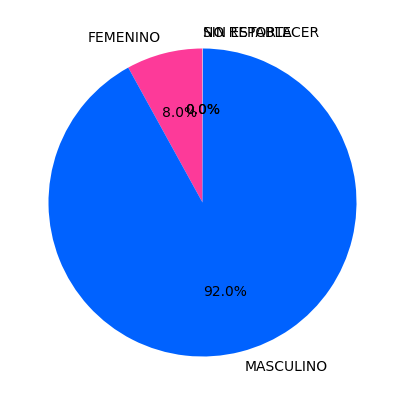

In [116]:
# Lista de colores ordenada
colores_ordenados =  [colores_sexo.get(nombre) for nombre in df_sexo_agrupado['sexo']]
# Se Visualizan los datos a través de un pie chart 
plt.figure(figsize=(10,5))

plt.pie(
    df_sexo_agrupado['total_homicidios'],
    labels=df_sexo_agrupado['sexo'],
    autopct='%1.1f%%',
    colors=colores_ordenados,
    startangle=90
)


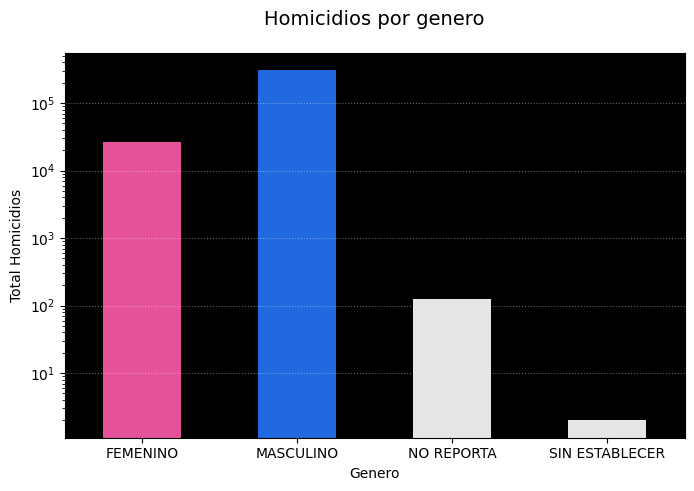

In [94]:
# Gestión de los patrones generales de visualización.
fig2, ax2 = plt.subplots(figsize=(8,5), facecolor='white')
ax.set_facecolor('black')

# Visualización de la cantidad de homicidios por sexo.
sns.barplot(
    data=df_sexo_agrupado,
    x='sexo',
    y='total_homicidios',
    hue='sexo',
    palette=colores_sexo,
    estimator=sum,
    errorbar=None,
    ax=ax,
    width=0.5
)

# Definición de parametros estéticos.
ax.set_yscale('log')
ax.set_title('Homicidios por genero', fontsize=14, color='black', pad=20)
ax.set_xlabel('Genero', fontsize=10, color='black')
ax.set_ylabel('Total Homicidios', fontsize=10, color='black')
ax.grid(axis='y', color='white',linestyle=':', alpha=0.4)

In [45]:
df_sexo_agrupado

,total_homicidios
sexo,
FEMENINO,26745
MASCULINO,307037
NO REPORTA,125
SIN ESTABLECER,2


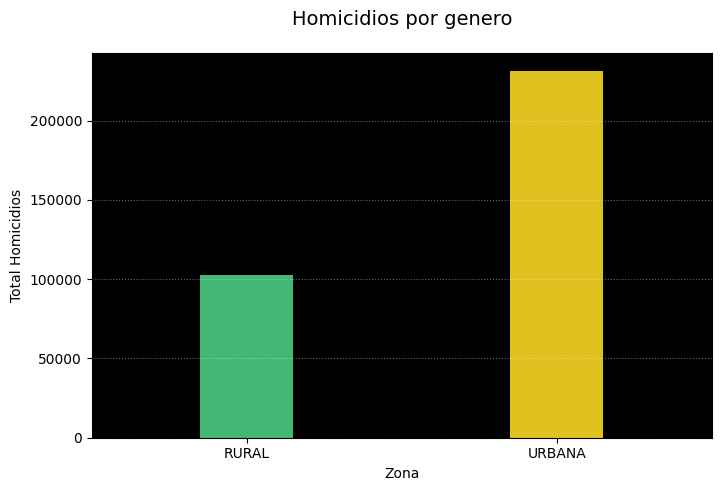

In [50]:
#  se crea sub df de la cantidad de homicidios por sexo.
df_zona = df[['zona','total_homicidios']].copy()
df_zona_agrupada = df_zona.groupby(['zona']).sum()

# Gestión de los patrones generales de visualización.
fig, ax = plt.subplots(figsize=(8,5), facecolor='white')
ax.set_facecolor('black')

# Visualización de la cantidad de homicidios por sexo.
sns.barplot(
    data=df_zona_agrupada,
    x='zona',
    y='total_homicidios',
    hue='zona',
    palette=colores_zona,
    estimator=sum,
    errorbar=None,
    ax=ax,
    width=0.3
)

# Definición de parametros estéticos.
ax.set_title('Homicidios por genero', fontsize=14, color='black', pad=20)
ax.set_xlabel('Zona', fontsize=10, color='black')
ax.set_ylabel('Total Homicidios', fontsize=10, color='black')
ax.grid(axis='y', color='white',linestyle=':', alpha=0.4)

In [ ]:
df.sample(20)

## Se define una serie de tiempo para posiblemente predecir la cantidad de homicidios en años venideros. 

In [68]:
# confirmación de la integridad de los datos.
min_homicidios = df_fecha['total_homicidios'].min().copy()
if min_homicidios >= 0:
    print('integridad de los datos confirmada')
else:
    print('Se identificaron posibles gaps\n')
    print(f' los pósibles gaps son: {min_homcidios}')

integridad de los datos confirmada


In [87]:
df_fecha_agrupada = df_fecha.groupby(['fecha']).sum()
df_fecha_agrupada.sort_values(by=['total_homicidios'], ascending=False).head()

,total_homicidios
fecha,
2003-01-01,144
2004-01-01,137
2005-01-01,132
2015-01-01,125
2009-01-01,121


In [88]:
df_fecha_agrupada.sort_values(by=['total_homicidios'], ascending=False).tail()

,total_homicidios
fecha,
2016-09-13,10
2021-04-06,10
2020-03-24,9
2017-03-16,9
2020-04-10,7
